# Projected quantum kernels


In [2]:
import sys
import os
# to import quask, move from docs/source/notebooks to src
# sys.path.append('../../../src')

In [2]:
# se the default implementation you want to use
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import PennylaneKernel

def create_pennylane_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return PennylaneKernel(ansatz, measurement, type, device_name="default.qubit", n_shots=None)

KernelFactory.add_implementation('pennylane_noiseless', create_pennylane_noiseless)
KernelFactory.set_current_implementation('pennylane_noiseless')
print(KernelFactory._KernelFactory__implementations)
print(KernelFactory._KernelFactory__current_implementation)

{'pennylane_noiseless': <function create_pennylane_noiseless at 0x14ce80e00>}
pennylane_noiseless


To understand Projected Quantum Kernels we should understand the limitations
of "traditional" quantum kernels. These limitations have very deep implications
in the understanding of kernel methods also on a classical perspective.

## Expressibility and curse of dimensionality in kernel methods

When approaching a ML problem we could ask if it makes sense at all to use QML techniques, such as quantum kernel methods. We understood in the last years \[kbs21\],\[Hua21\] that having a large Hilbert space where we can compute classically intractable inner products does not guarantee an advantage. But, why?

When dealing with kernel methods, whether classical or quantum, we must exercise caution when working in high-dimensional (or even infinite-dimensional) Hilbert spaces. This is due to the fact that in
high dimensions, the problem of generalization becomes hard, _i.e._ the trained kernel is prone to overfitting.
In turn, an exponential (in the number of features/qubits) number of datapoints are needed to learn the target function we aim to estimate. These phenomena are explored in the [upcoming tutorial](xxx).

For instance, in the classical context, the Gaussian kernel maps any $\mathbf{x} \in \mathbb{R}^d$ to a multi-dimensional Gaussian distribution with an average of $\mathbf{x}$ and a covariance matrix of $\sigma I$. When $\sigma$ is small, data points are mapped to different regions of this infinite-dimensional Hilbert space, and $\kappa(\mathbf{x}, \mathbf{x}') \approx 0$ for all $\mathbf{x} \neq \mathbf{x}'$. This is known as the phenonenon of _curse of dimensionality_, or _orthogonality catastrophe_. To avoid this, a larger $\sigma$ is chosen to ensure that most data points relevant to our task have some nontrivial overlap.

As the Hilbert space for quantum systems grows exponentially with the number of qubits $n$, similar challenges can arise when using quantum kernels. This situation occurs with expressible $U(\cdot)$, which allows access to various regions within the Hilbert space. In such cases, similar to classical kernels, techniques must be employed to control expressibility and, consequently, the model's complexity.

### Projection as expressibility control

The authors of \[Hua21\], who initially addressed the challenge of the exponential dimensionality of Hilbert space in the context of quantum kernels, have introduced the concept of _projected quantum kernels_ to mitigate this issue. Then, in \[kbs21\] they proved as this projected kernel must intertwine with a correct inductive bias to obtain some good performance.

The concept is straightforward: first, the unitary transformation $U$ maps classical data into the Hilbert space of the quantum system. Subsequently, a projection maps these elements back to a lower-dimensional Hilbert space. The overall transformation, thanks to the contribution of $U$, remains beyond the capabilities of classical kernels.

For a single data point encoded in the quantum system, denoted as $\rho_x = U(x) \rho_0 U(x)$, projected quantum kernels can be implemented in two different ways:
- We can implement the feature map $\phi(x) = \mathrm{\tilde{Tr}}[\rho_x]$, with $\mathrm{\tilde{Tr}}$ representing partial trace.
- Alternatively, we can implement the feature map $\phi(x) = \{ \mathrm{Tr}[\rho_x O^{(j)}] \}_{j=1}^k$, where the observable $O^{(j)}$ is employed for the projections.

Finally, the kernel $\kappa(x, x')$ is explicitly constructed as the inner product between $\phi(x)$ and $\phi(x')$.


### Implementation of projected quantum kernel in _quask_

We first create the parameterized quantum circuit $U$ as in the previous tutorials. 

In [3]:
from quask.core import Ansatz, Kernel, KernelFactory, KernelType

N_FEATURES = 2
N_OPERATIONS = 3
N_QUBITS = 2
ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
ansatz.initialize_to_identity()
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="ZZ", new_bandwidth=1.0)
ansatz.change_operation(1, new_feature=1, new_wires=[0, 1], new_generator="XX", new_bandwidth=1.0)
ansatz.change_operation(2, new_feature=2, new_wires=[0, 1], new_generator="IX", new_bandwidth=0.123)

Now, by employing the SWAP test over a subset of the $n$ qubits, only a small and constant number of qubits are measured, hence projecting in the subspace relative to those qubit selected by the SWAP test. This calculation is equivalent to performing the inner product between partial traces of two quantum-encoded data points. 

In the following example, the measurement is performed only on the first of two qubits.

In [5]:
kernel = KernelFactory.create_kernel(ansatz, "ZI", KernelType.SWAP_TEST)

We can also obtain the kernel by projecting onto a single observable described by a Pauli string.

In [ ]:
kernel = KernelFactory.create_kernel(ansatz, "XY", KernelType.OBSERVABLE)

Multiple observable can be tested if we compose together kernel functions made of different observables. Due to the properties of positive semidefinite functions, the sum and product and tensor of positive semidefinite operators is again positive semidefinite.

## Learning of quantum processes

The projected quantum kernel finds application in the realm of learning a quantum process, described by a function:

$$f(x) = \mathrm{Tr}[U^\dagger(x) \rho_0 U(x) O]$$

Here, $U$ represents a parameterized quantum circuit, $\rho_0$ is the initial state, and $O$ stands for the observable. This family of functions carries significant theoretical importance, as it has facilitated the formal demonstration of quantum advantages. It also holds practical significance, as certain use cases in physics and chemistry can be conceptualized as quantum processes.

We are given a dataset, denoted as $\{ (x^{(j)}, y^{(j)}) \}_{j=1}^m$. Additionally, we assume that each label in this dataset is noise-free, meaning that $y^{(j)} = f(x^{(j)})$.


## Create a Quantum Dataset 

We can use a $U$ quantum circuit inspired by quantum many-body physics, e.g. a Ising Hamiltonian with transverse field (open boundary condition is implemented by linear entanglement),
$$ H = \sum_{i=1}^{n-1} \sigma_i^z \sigma_{i+1}^z + \lambda \sum_{i=1}^n \sigma_i^x $$
where $n$ is the number of qubits.

Then, U for the $j-th$ datapoint $\{x_j^{(i)}\}_{i=1}^n$ (which has $i$ number of features equal to the number of qubits $n$) will look like:
$$ U (x_j) = \exp(\sum_{i=1}^{n-1}x_{ji}x_{ji+1}\sigma_i^z \sigma_{i+1}^z + \sum_{i=1}^n x_{ji}\sigma_i^x) $$

In [4]:
# let us define the Ansatz which implements this
def ManyBodyAnsatz(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # linear CZ entanglement
    for j in range(N_QUBITS-1):
        ansatz.change_operation(j, new_feature=N_QUBITS+j, new_wires=[j, j+1], new_generator="ZZ", new_bandwidth=bandwidth)

    # single qubit rotations in x: RX wall
    for i in range(N_QUBITS-1):
        j += 1
        ansatz.change_operation(j, new_feature=i, new_wires=[i, i+1], new_generator="XI", new_bandwidth=bandwidth)
    ansatz.change_operation(2*N_QUBITS-2, new_feature=N_QUBITS-1, new_wires=[N_QUBITS-1, 0], new_generator="XI", new_bandwidth=bandwidth)
    return ansatz

# help funciton to select on which qubit we want to perform our measurement
def measurement_qubit(N_QUBITS, measurement):
    pauli_string = ""
    for i in range(N_QUBITS):
        if i < measurement:
            pauli_string = pauli_string + "I"
        if i == measurement:
            pauli_string = pauli_string + "Z"
        if i > measurement:
            pauli_string = pauli_string + "I"
    return pauli_string

# we define the function which will give us quantum labels for our dataset
def QuantumTargetFunction(ansatz, N_QUBITS, measurement):
    kernel = KernelFactory.create_kernel(ansatz, measurement_qubit(N_QUBITS=N_QUBITS, measurement=measurement), KernelType.OBSERVABLE)
    return kernel

Now, we can take a classical dataset, e.g. the _iris_ (check tutorial [Getting Started]("../getting_started.html")) dataset and change its labels with the quantum ones

In [5]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

N_ELEMENTS_PER_CLASS = 10
digits = load_digits()
data, labels = load_digits(return_X_y=True)
# X = np.row_stack([digits.data[0:N_ELEMENTS_PER_CLASS], digits.data[50:50+N_ELEMENTS_PER_CLASS]])
X_reduced = PCA(n_components=2).fit_transform(data)
y = np.array([0] * N_ELEMENTS_PER_CLASS + [1] * N_ELEMENTS_PER_CLASS)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X_reduced)

As explained already in the first tutorial on [Quantum Kernels](../tutorials_quantum/quantum_0_intro.html), The features of the Unitary operator can be customed. We need to add them to a datapoint's feature. Here $x^{(j)}$ lives in a $\mathbb{R}^4$ space. We can add, for the $i,i+1$ $ZZ$ interaction, the product of the nearest-neighbor features to the datapoint. Hence, $x = \{x_0,x_1,x_2,x_3,x_0x_1,x_1x_2,x_2x_3\} \in \mathbb{R}^7$, in general, if the original vector has $n$ features, for this Unitary we will need $2n-1$ features. In this way, our `ManyBodyAnsatz` knows where to take the features to build the parametrized circuit.

In [6]:
X_new = []
for x in X:
    for i in range(x.shape[0]-1):
        x = np.append(x, x[i]*x[i+1])
    X_new.append(x)

print(np.asarray(X_new).shape)

(20, 7)


In [7]:
# instantiate the ansatz to sample from a quantum distribution
N_FEATURES = 7
N_QUBITS = 4
N_OPERATIONS = 7
bandwidth = 1
ansatz = ManyBodyAnsatz(N_FEATURES=N_FEATURES, N_QUBITS=N_QUBITS, N_OPERATIONS=N_OPERATIONS, bandwidth=bandwidth)
kernel_proj_1 = QuantumTargetFunction(ansatz=ansatz, N_QUBITS=N_QUBITS, measurement=0)
kernel_proj_4 = QuantumTargetFunction(ansatz=ansatz, N_QUBITS=N_QUBITS, measurement=3)
kernel_fid = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)
y_quantum = [kernel_proj_1.kappa(x,x) for x in X_new]
new_labels = [1 if y >= 1/2 else 0 for y in y_quantum]

We have created a quantum dataset with labels, $i.e.$ classes, sampled from a quantum distribution given by our quantum feature map.
Now, we can use the dataset as always to test our kernels

In [8]:
# Split the data into training and testing sets
X_new = np.array(X_new)
X_train, X_test, y_train, y_test = train_test_split(X_new, new_labels, test_size=0.5, random_state=5454)

# Instantiate a machine learning model
model_proj_1 = SVC(kernel='precomputed')
model_proj_4 = SVC(kernel='precomputed')
model_fid = SVC(kernel='precomputed')
model_lin = SVC(kernel='precomputed')
model_rbf = SVC(kernel='precomputed')

# Fit the model to the training data
K_train_1 = kernel_proj_1.build_kernel(X_train, X_train)
model_proj_1.fit(K_train_1, y_train)
K_train_4 = kernel_proj_4.build_kernel(X_train, X_train)
model_proj_4.fit(K_train_4, y_train)
K_train_fid = kernel_fid.build_kernel(X_train, X_train)
model_fid.fit(K_train_fid, y_train)
K_train_lin = linear_kernel(X_train)
model_lin.fit(K_train_lin, y_train)
K_train_rbf = rbf_kernel(X_train)
model_rbf.fit(K_train_rbf, y_train)

# Predict the labels for the test data
K_test_1 = kernel_proj_1.build_kernel(X_test, X_train)
y_pred_1 = model_proj_1.predict(K_test_1)
K_test_4 = kernel_proj_4.build_kernel(X_test, X_train)
y_pred_4 = model_proj_4.predict(K_test_4)
K_test_fid = kernel_fid.build_kernel(X_test, X_train)
y_pred_fid = model_fid.predict(K_test_fid)
K_test_lin = linear_kernel(X_test, X_train)
y_pred_lin = model_lin.predict(K_test_lin)
K_test_rbf = rbf_kernel(X_test, X_train)
y_pred_rbf = model_rbf.predict(K_test_rbf)

# Calculate the accuracy
accuracy_1 = np.sum(y_test == y_pred_1) / len(y_test)
print("Accuracy projection on (first) qubit 1:", accuracy_1)
accuracy_4 = np.sum(y_test == y_pred_4) / len(y_test)
print("Accuracy projection on (last) qubit 4:", accuracy_4)
accuracy_fid = np.sum(y_test == y_pred_fid) / len(y_test)
print("Accuracy fidelity:", accuracy_fid)
accuracy_lin = np.sum(y_test == y_pred_lin) / len(y_test)
print("Accuracy linear:", accuracy_lin)
accuracy_rbf = np.sum(y_test == y_pred_rbf) / len(y_test)
print("Accuracy rbf:", accuracy_rbf)

Accuracy projection on (first) qubit 1: 0.7
Accuracy projection on (last) qubit 4: 0.4
Accuracy fidelity: 0.6
Accuracy linear: 0.6
Accuracy rbf: 0.6


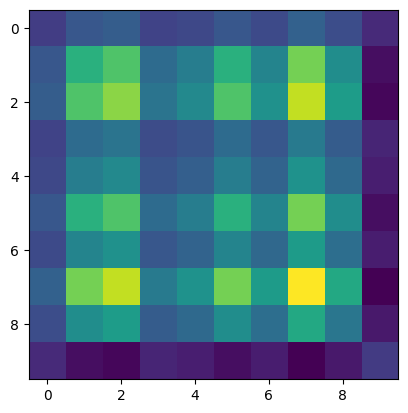

In [133]:
import matplotlib.pyplot as plt

plt.imshow(K_train_1)

In [8]:
print([K_train_1[i,i] for i in range(len(K_train_1))])
print(y_train)

accuracy_1 = np.sum(y_train == model_proj_1.predict(K_train_1)) / len(y_train)
accuracy_4 = np.sum(y_train == model_proj_4.predict(K_train_4)) / len(y_train)
accuracy_fid = np.sum(y_train == model_fid.predict(K_train_fid)) / len(y_train)
accuracy_lin = np.sum(y_train == model_lin.predict(K_train_lin)) / len(y_train)
accuracy_rbf = np.sum(y_train == model_rbf.predict(K_train_rbf)) / len(y_train)
print("Training accuracy projection on (first) qubit 1:", accuracy_1)
print("Training accuracy projection on (last) qubit 4:", accuracy_4)
print("Training accuracy fidelity:", accuracy_fid)
print("Training accuracy linear:", accuracy_lin)
print("Training accuracy rbf:", accuracy_rbf)

[0.03671272559474694, 0.5715453830052944, 0.7968808921734044, 0.09647781596276615, 0.1805535420850637, 0.5715453830052948, 0.21989891011575627, 0.9993946120620129, 0.2838746697951175, 0.030764066789510918]
[0, 1, 1, 0, 0, 1, 0, 1, 0, 0]
Training accuracy projection on (first) qubit 1: 0.8
Training accuracy projection on (last) qubit 4: 0.6
Training accuracy fidelity: 0.9
Training accuracy linear: 0.9
Training accuracy rbf: 0.9


### S-value

We can train a kernel machine on a dataset using a kernel $\kappa$. The resulting model takes the form $h(x) = w^\top \phi(x)$. 
This representation is a kernel machine in its primal form, and the corresponding kernel Gram matrix is defined as $K = [\kappa(x^{(i)}, x^{(j)})]_{i,j=1}^m$.  Assuming that the kernel Gram matrix is normalized, i.e., $\mathrm{Tr}[K]=m$, we can define the _s-value_, a quantity that depends on the process $f$, the input data, and the kernel Gram matrix $K$:

$$s_K = \sum_{i,j=1}^m (K_{i,j}^{-1}) \, f(x^{(i)}) \, f(x^{(j)})$$

This value quantifies how well the kernel function captures the behavior of the quantum process. The kernel is indeed able to capture the relationship within the data if:

$$\kappa(x^{(i)}, x^{(j)}) \approx f(x^{(i)}) \, f(x^{(j)})$$

It's important to note that $s_K = \lVert w \rVert$, making it a measure of the model's complexity. Higher values of $s_K$ suggest that the kernel machine $h$ becomes a more complex function, which can lead to overfitting and poor generalization performance.


In [18]:
from quask.evaluator import EssModelComplexityEvaluator

sm_eval = EssModelComplexityEvaluator()
sm_1 = sm_eval.evaluate(kernel=kernel_proj_1, K=K_train_1, X=None, y=np.asarray(y_train))
print(f"Model complexity of the training projected kernel on qubit 1: {sm_1:.3f}")
sm_4 = sm_eval.evaluate(kernel=kernel_proj_4, K=K_train_4, X=None, y=np.asarray(y_train))
print(f"Model complexity of the training projected kernel on qubit 4: {sm_4:.3f}")
sm_fid = sm_eval.evaluate(kernel=kernel_fid, K=K_train_fid, X=None, y=np.asarray(y_train))
print(f"Model complexity of the training fidelity kernel: {sm_fid:.3f}")
sm_lin = sm_eval.evaluate(kernel=None, K=K_train_lin, X=None, y=np.asarray(y_train))
print(f"Model complexity of the training linear kernel: {sm_lin:.3f}")
sm_rbf = sm_eval.evaluate(kernel=None, K=K_train_rbf, X=None, y=np.asarray(y_train))
print(f"Model complexity of the training rbf kernel: {sm_rbf:.3f}")

Model complexity of the training projected kernel on qubit 1: 0.807
Model complexity of the training projected kernel on qubit 4: 0.648
Model complexity of the training fidelity kernel: 8.060
Model complexity of the training linear kernel: 2.031
Model complexity of the training rbf kernel: 8.010


We can also check if the feature maps we choose are expressive in terms of the `HaarEvaluator`

In [23]:
from quask.evaluator import HaarEvaluator
he = HaarEvaluator(n_bins=40, n_samples=10000)
cost = he.evaluate(kernel=kernel_proj_1, K=K_train_1, X=None, y=None)
print(f"Cost (norm) of the training projected kernel on qubit 1: {cost:.3f}")
cost = he.evaluate(kernel=kernel_proj_4, K=K_train_4, X=None, y=None)
print(f"Cost (norm) of the training projected kernel on qubit 4: {cost:.3f}")
cost = he.evaluate(kernel=kernel_fid, K=K_train_fid, X=None, y=None)
print(f"Cost (norm) of the training fidelity kernel: {cost:.3f}")

Cost (norm) of the training projected kernel on qubit 1: 0.375
Cost (norm) of the training projected kernel on qubit 4: 0.374
Cost (norm) of the training fidelity kernel: 0.374


### Geometric difference

While the quantity $s_K$ compare a kernel and the target function, the geometric difference quantifies the divergence between two kernels. 

Assume for the two kernel matrices $K_1, K_2$ that their trace is equal to $m$. This is a valid assumption for quantum kernels, as the inner product between unitary vectors (or corresponding density matrices) is one, which then has to be multiplied for the $m$ elements. For classical kernels, the Gram matrix needs to be normalized. 

The geometric difference is defined by
$$g(K_1, K_2) = \sqrt{\lVert \sqrt{K_2} K_1^{-1} \sqrt{K_2} \rVert_{\infty}},$$
where $\lVert \cdot \rVert_\infty$ is the spectral norm, i.e. the largest singular value. 

One should use the geometric difference to compare the quantum kernel $K_Q$ with several classical kernels $K_{C_1}, K_{C_2}, ...$. Then, $\min g(K_C, K_Q)$ has to be calculated: 
* if this difference is small, $g(K_C, K_Q) \ll \sqrt{m}$, then one of the classical kernels, the one with the smallest geometric difference, is guaranteed to provide similar performances;
* if the difference is high, $g(K_C, K_Q) \approx \sqrt{m}$, the quantum kernel might outperform all the classical kernels tested. 

### Geometry Test

The geometry test, introduced by [Hua21], serves as a means to assess whether a particular dataset holds the potential for a quantum advantage or if such an advantage is unlikely. The test operates as follows:

- When $g(K_C, K_Q) \ll \sqrt{m}$, a classical kernel exhibits behavior similar to the quantum kernel, rendering the use of the quantum kernel redundant.

- When $g(K_C, K_Q) \approx \sqrt{m}$, the quantum kernel significantly deviates from all tested classical kernels. The outcome depends on the complexity of classical kernel machines:
    - If the complexity of any classical kernel machine is low ($s_{K_C} \ll m$), classical kernels perform well, and the quantum kernel's divergence from classical  $K_C$, doesn't yield superior performance.
    - When the complexity of all classical kernel machines is high ($s_{K_C} \approx m$), classical models struggle to learn the function $f$. In this scenario:
        - If the quantum model's complexity is low ($s_{K_Q} \ll m$), the quantum kernel successfully solves the task while the classical models do not.
        - If the quantum model's complexity is high ($s_{K_Q} \approx m$), even the quantum model struggles to solve the problem.


In [19]:
from quask.evaluator import GeometricDifferenceEvaluator

lam = 0.0001 # regularization 
g_eval = GeometricDifferenceEvaluator([K_train_lin,K_train_rbf], lam)
g_p1 = g_eval.evaluate(kernel=kernel_proj_1, K=K_train_1, X=None, y=None)
g_p1 = [round(g,3) for g in g_p1]
g_p4 = g_eval.evaluate(kernel=kernel_proj_4, K=K_train_4, X=None, y=None)
g_p4 = [round(g,3) for g in g_p4]
g_fid = g_eval.evaluate(kernel=kernel_fid, K=K_train_fid, X=None, y=None)
g_fid = [round(g,3) for g in g_fid]
print(f"geometric difference of training projected kernel on qubit 1 with linear and rbf: {g_p1} - sqrt of m: {np.sqrt(len(X_train)):.3f}")
print(f"geometric difference of training projected kernel on qubit 4 with linear and rbf: {g_p4} - sqrt of m: {np.sqrt(len(X_train)):.3f}")
print(f"geometric difference of training fidelity kernel with linear and rbf: {g_fid} - sqrt of m: {np.sqrt(len(X_train)):.3f}")

geometric difference of training projected kernel on qubit 1 with linear and rbf: [0.869, 2.517] - sqrt of m: 3.162
geometric difference of training projected kernel on qubit 4 with linear and rbf: [4.219, 1.821] - sqrt of m: 3.162
geometric difference of training fidelity kernel with linear and rbf: [2.862, 1.481] - sqrt of m: 3.162


Let us follow the geometry test above:
* for the Quantum Kernel Projected on the first qubit we have $g_{1,lin} = 0.869 < \sqrt{m}$ and $g_{1,rbf} = 2.517 \approx \sqrt{m}$
    - Then, we check the _model complexity_ of the rbf kernel and we see that is $s_{K_{rbf}} = 8.010 \approx m$ there is chance of advantage
    - The model complexity of the projected kernel on the first qubit is $s_{K_{p1}} = 0.807 \ll m$
    - We confirm there is **potential quantum advantage** over the rbf kernel for the Quantum Kernel Projected on the first qubit
* for the Quantum Kernel Projected on the lastt qubit we have $g_{4,lin} = 4.219 \approx \sqrt{m}$ and $g_{4,rbf} = 1.821 \approx \sqrt{m}$
    - Then, we check the _model complexity_ of the linear kernel and we see that is $s_{K_{lin}} = 2.031 < m$ so the classical kernel is still able to perform well
    - In addition, the model complexity of the projected kernel on the last qubit is $s_{K_{p4}} = 0.648 \ll m$ that could also indicate a poorly expressive feature map (underfitting)
    - We confirm there is **NO quantum advantage** over the linear nor the rbf kernel for the Quantum Kernel Projected on the last qubit
* for the Quantum Fidelity Kernel we have $g_{fid,lin} = 2.862 \approx \sqrt{m}$ and $g_{fid,rbf} = 1.481 \approx \sqrt{m}$
    - Then, we check the _model complexity_ of the linear kernel and we see that is $s_{K_{lin}} = 2.031 < m$ so the classical kernel is still able to perform well
    - In addition, the model complexity of the projected kernel on the last qubit is $s_{K_{fid}} = 8.060 \ll m$ that could also indicate a too expressive feature map (overfitting)
    - We confirm there is **NO quantum advantage** over the linear nor the rbf kernel for the Quantum Kernel Projected on the last qubit

All these results are in line with the accuracies we registered

## References

\[Hua21\] Huang, HY., Broughton, M., Mohseni, M. et al. Power of data in quantum machine learning. Nat Commun 12, 2631 (2021). https://doi.org/10.1038/s41467-021-22539-9